### Abstract¶
#### This notebook pertains to a representative NER use case adopted from a Kaggle dataset (https://www.kaggle.com/ritvik1909/named-entity-recognition/notebook). NER is particularly useful for parsing unstructured log files. 

##### we use flair (https://github.com/flairNLP/flair) an open source library from Humboldt University of Berlin. 

In [18]:
# !pip3 uninstall typing -y
# !pip3 install flair

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style('darkgrid')

In [5]:
data = pd.read_csv(
    "ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, 
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
data['sentence_idx'] = data['sentence_idx'].apply(int)
print(data.shape)
data.head()

/usr/local/Cellar/jupyterlab/3.1.14/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/Cellar/jupyterlab/3.1.14/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


#### Comments

* There are 35,177 sentences in the repository with 22 being the most frequently occuring sentence lenghts in words. 
* There are 30,172 unique words.

Number of Sentences: 35177
Maximum sequence length: 140
Number of unique words: 30172


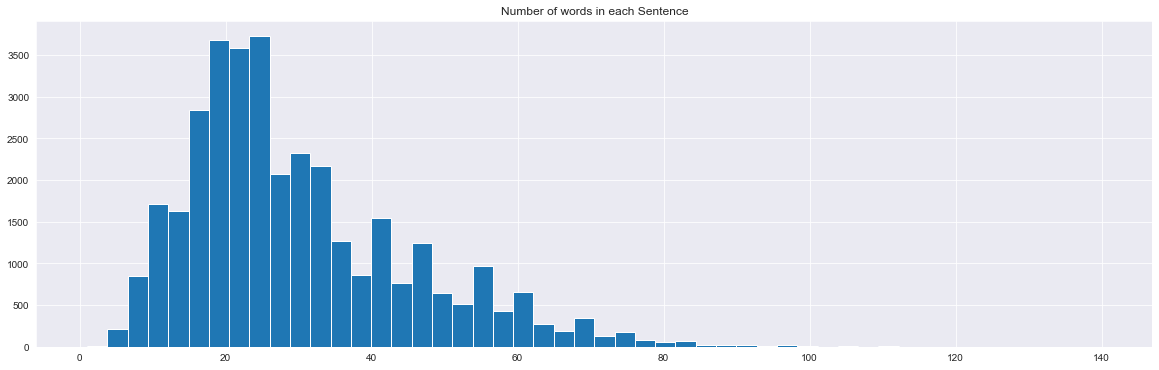

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(data['sentence_idx'].value_counts().values, bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = np.max(data['sentence_idx'].value_counts().values)
print('Number of Sentences:', data['sentence_idx'].nunique())
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
n_words = len(words)
print('Number of unique words:', n_words)

### Comments

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk
The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

Number of unique Tags: 17


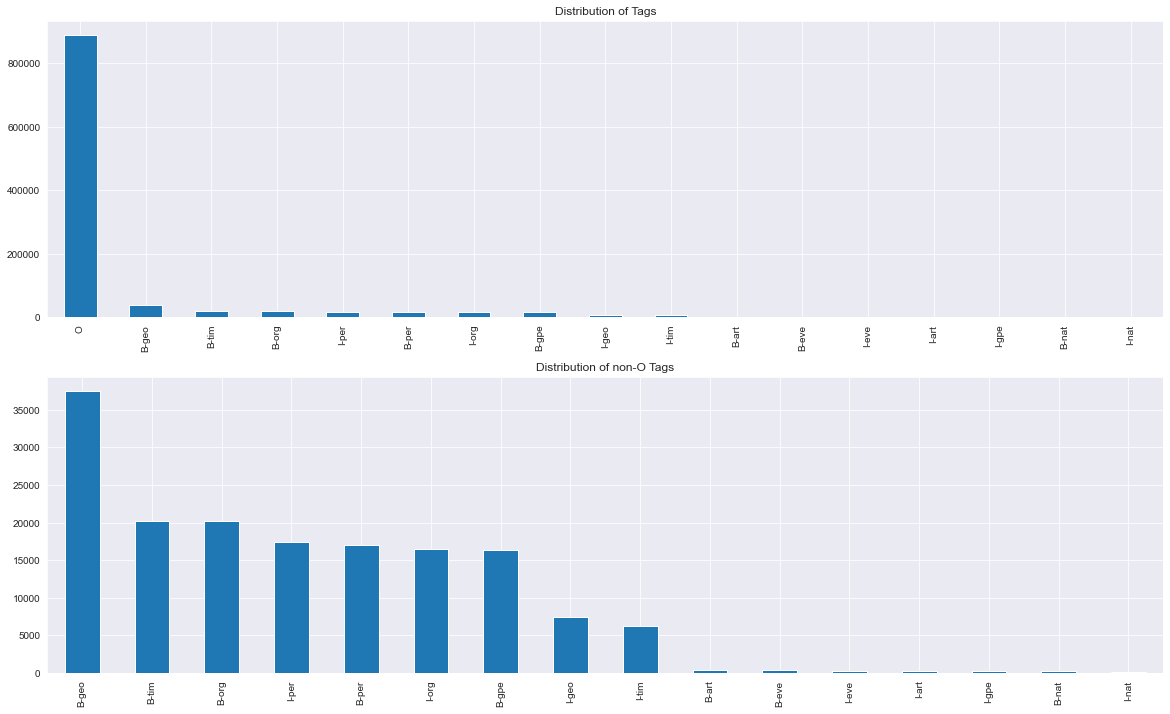

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

### Modelling

In [10]:
mask = data['sentence_idx'].ne(data['sentence_idx'].shift(-1))
data1 = pd.DataFrame('',index=mask.index[mask] + .5, columns=data.columns)

data = pd.concat([data, data1]).sort_index().reset_index(drop=True).iloc[:-1]
data[['word', 'tag']].to_csv('data.txt', sep=' ', index=False, header=False)

In [3]:
from flair.data import Corpus, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from typing import List

In [12]:
columns = {0 : 'text', 1 : 'tag'}
data_folder = '.'

corpus: Corpus = ColumnCorpus(data_folder, columns, train_file = 'data.txt')

2021-12-06 06:10:20,794 Reading data from .
2021-12-06 06:10:20,796 Train: data.txt
2021-12-06 06:10:20,797 Dev: None
2021-12-06 06:10:20,799 Test: None


In [13]:
tag_type = 'tag'
tag_dictionary = corpus.make_label_dictionary(tag_type)

2021-12-06 06:10:41,974 Computing label dictionary. Progress:


100%|██████████████████████████████████████████████████████████████████████████| 38947/38947 [00:02<00:00, 17360.38it/s]


2021-12-06 06:10:44,262 Corpus contains the labels: tag (#851600)
2021-12-06 06:10:44,263 Created (for label 'tag') Dictionary with 18 tags: <unk>, O, B-geo, B-gpe, B-per, B-org, I-org, B-tim, B-art, I-art, I-per, I-geo, I-gpe, I-tim, B-nat, B-eve, I-eve, I-nat


In [14]:
embedding_types : List[TokenEmbeddings] = [WordEmbeddings('glove')]
embeddings : StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

In [15]:
tagger : SequenceTagger = SequenceTagger(
    hidden_size=256, embeddings=embeddings, tag_dictionary=tag_dictionary, 
    tag_type=tag_type, use_crf=True
)
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=20, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)


In [16]:
trainer : ModelTrainer = ModelTrainer(tagger, corpus)
trainer.train('model', learning_rate=0.1, mini_batch_size=32, max_epochs=15)

2021-12-06 06:11:29,553 ----------------------------------------------------------------------------------------------------
2021-12-06 06:11:29,555 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=20, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2021-12-06 06:11:29,558 ----------------------------------------------------------------------------------------------------
2021-12-06 06:11:29,559 Corpus: "Corpus: 38947 train + 4328 dev + 4808 test sentences"
2021-12-06 06:11:29,561 ----------------------------------------------------------------------------------------------------
2021-12-06 06:1

/Users/rajat.ghosh/Library/Python/3.9/lib/python/site-packages/flair/trainers/trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2021-12-06 06:11:50,375 epoch 1 - iter 121/1218 - loss 0.69431586 - samples/sec: 186.54 - lr: 0.100000
2021-12-06 06:12:12,841 epoch 1 - iter 242/1218 - loss 0.54030170 - samples/sec: 172.46 - lr: 0.100000
2021-12-06 06:12:40,230 epoch 1 - iter 363/1218 - loss 0.47341169 - samples/sec: 141.46 - lr: 0.100000
2021-12-06 06:13:03,744 epoch 1 - iter 484/1218 - loss 0.43168043 - samples/sec: 164.77 - lr: 0.100000
2021-12-06 06:13:35,901 epoch 1 - iter 605/1218 - loss 0.40049074 - samples/sec: 120.48 - lr: 0.100000
2021-12-06 06:14:04,021 epoch 1 - iter 726/1218 - loss 0.37773971 - samples/sec: 137.79 - lr: 0.100000
2021-12-06 06:14:25,195 epoch 1 - iter 847/1218 - loss 0.35914938 - samples/sec: 182.98 - lr: 0.100000
2021-12-06 06:14:47,677 epoch 1 - iter 968/1218 - loss 0.34449900 - samples/sec: 172.33 - lr: 0.100000
2021-12-06 06:15:10,804 epoch 1 - iter 1089/1218 - loss 0.33112045 - samples/sec: 167.54 - lr: 0.100000
2021-12-06 06:15:34,699 epoch 1 - iter 1210/1218 - loss 0.32062935 - sam

{'test_score': 0.806965308792349,
 'dev_score_history': [0.7116816716683338,
  0.7550729984715122,
  0.7580186973813335,
  0.7714579055441478,
  0.7779764032892384,
  0.7862448703963428,
  0.7905834186284545,
  0.7910211177583474,
  0.7909270216962525,
  0.7920268483677413,
  0.7898871877518131,
  0.7936283185840708,
  0.7959246051961284,
  0.8004879784476185,
  0.7948613791002336],
 'train_loss_history': [0.31989428988304874,
  0.20114687849289378,
  0.1798615436052257,
  0.1680163265450452,
  0.1609402766659989,
  0.15581015773645976,
  0.1519884788850038,
  0.14974649016316255,
  0.14636980989831555,
  0.14540230408359883,
  0.14361384017302878,
  0.1417896346230639,
  0.14055476008137943,
  0.1394249412318024,
  0.1379107620325263],
 'dev_loss_history': [tensor(0.1611),
  tensor(0.1232),
  tensor(0.1193),
  tensor(0.1124),
  tensor(0.1046),
  tensor(0.1037),
  tensor(0.0996),
  tensor(0.0977),
  tensor(0.0965),
  tensor(0.0965),
  tensor(0.0968),
  tensor(0.0947),
  tensor(0.0938),

In [4]:
model = SequenceTagger.load('model/final-model.pt')

sentence = Sentence('Rajat went to Georgia Tech, Atlanta. Rajat lives in San Jose, USA and works at Nutanix.')

model.predict(sentence)
print(sentence.to_tagged_string())


2021-12-06 14:31:21,055 loading file model/final-model.pt
Rajat <B-per> went to Georgia <B-geo> Tech <I-geo> , Atlanta <B-geo> . Rajat lives in San <B-geo> Jose <I-geo> , USA <B-geo> and works at Nutanix <B-geo> .
